In [198]:
import numpy as np
from functions import file_handler
from functions.functions import load_data_forGridSearch
from sklearn.metrics import r2_score, mean_squared_error
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [199]:
def check_all(predictions, inputs, outputs, thresh=0.9):
    idx_test = np.loadtxt('/home/samuelch/src/deep-fluids/data/cmag_dataset/idx_test.txt', np.int)
    idx_to_r2 = dict()
    for i in idx_test:
        mask_example = np.alltrue(inputs[:,3:] == currents[i,:], axis=1)
        idx_to_r2[i] = r2_score(predictions[mask_example,:], outputs[mask_example,:], multioutput='raw_values')
    bad_examples = set([k for k, v in idx_to_r2.iteritems() if np.any(v < thresh)])
    print('proportion of bad examples %f' % (float(len(bad_examples))/len(idx_test)))
    return idx_to_r2

In [200]:
X_test, y_test = load_data_forGridSearch("../Data", "test")
currents = file_handler.get_currents()
mlp_y_pred = np.load('../Models/ANN/predictions_ANN.npy')
rf_y_pred = np.load('../Models/RF/GridSearch_RF_predictions.npy')

In [201]:
mlp_y_pred

array([[-0.04851072,  0.06539685,  0.08980403],
       [-0.04942118,  0.06368315,  0.07834107],
       [-0.02920494,  0.08712065,  0.09127326],
       ...,
       [-0.01808998, -0.01199121, -0.01953992],
       [-0.01928816, -0.00304389, -0.01468845],
       [-0.02300133,  0.00466704, -0.00986709]], dtype=float32)

# Checking All Examples

In [202]:
idx_to_r2_mlp = check_all(mlp_y_pred, X_test, y_test)

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

In [ ]:
bad_mlp = set([k for k, v in idx_to_r2_mlp.iteritems() if np.any(v < 0.9)])

In [ ]:
idx_to_r2_rf = check_all(rf_y_pred, X_test, y_test, thresh=0.9)

In [ ]:
data_df = np.load('/home/samuelch/src/deep-fluids/log/notebook/results.npz')
idx_to_r2_df = dict(zip(data_df['tids'], data_df['r2']))

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.title('R2 (MLP)')
plt.plot(idx_to_r2_mlp.values())
plt.gca().get_xaxis().set_visible(False)
plt.subplot(3,1,2)
plt.title('R2 (RF)')
plt.gca().get_xaxis().set_visible(False)
plt.plot(idx_to_r2_rf.values())
plt.subplot(3,1,3)
plt.title('R2 (DF)')
plt.plot(idx_to_r2_df.values())

# Checking Only Bad Examples

In [ ]:
bad_df = np.load('/home/samuelch/src/deep-fluids/log/notebook/bad_idx.npy')

In [ ]:
bad_df

In [ ]:
idx_to_r2_bad_df = dict()
for i in bad_df:
    mask_example = np.alltrue(X_test[:,3:] == currents[i,:], axis=1)
    idx_to_r2_bad_df[i] = r2_score(mlp_y_pred[mask_example,:], y_test[mask_example,:], multioutput='raw_values')

In [ ]:
idx_to_r2_bad_df

In [ ]:
# proportion of examples that perform poorly  both with MLP and Deep Fluids compared to Deep Fluids
len(bad_mlp.intersection(set(bad_df))) / float(len(bad_df))

# Checking Alignment of Newer Bags
We suppose that there is a position difference between the bags starting with  "2018" and those starting with "5A". We want to check this by training a model on the first bag files and moving positions in space and verifying how it matches the recorded data.

In [337]:
# id is 731
#test_current = np.load('/home/samuelch/src/deep-fluids/data/cmag_dataset/v/0731.npz')['y']
#test_current = np.load('/home/samuelch/src/deep-fluids/data/cmag_dataset/v/2817.npz')['y']
test_current = np.load('/home/samuelch/src/deep-fluids/data/cmag_dataset/v/3007.npz')['y']

In [338]:
data = np.load('../Data/cmag_data/calibration_cube_processed/master_feature_matrix_v4.npy')
reference = data[np.alltrue(np.isclose(data[:,3:-3], test_current), axis=1),-3:]

In [339]:
idx_train = np.loadtxt('/home/samuelch/src/deep-fluids/data/cmag_dataset/idx_train.txt', dtype=np.int)
idx_test = np.loadtxt('/home/samuelch/src/deep-fluids/data/cmag_dataset/idx_test.txt', dtype=np.int)
assert(list(set(idx_train).union(set(idx_test))) == range(len(currents)))
# We load the train/test split that we used in DeepFluids
# The samples are organized by current samples and not individual magnetic field samples
train_data = np.zeros((len(idx_train) * 119, 14), np.float)
for i, idx in enumerate(idx_train):
    train_data[i*119:(i+1)*119, :] = data[(idx*119):((idx+1)*119),:]
test_data = np.zeros((len(idx_test) * 119, 14), np.float)
for i, idx in enumerate(idx_test):
    test_data[i*119:(i+1)*119, :] = data[(idx*119):((idx+1)*119),:]

AssertionError: 

In [267]:
positions = test_data[0:119,0:3]

In [268]:
from keras.models import Sequential, load_model
import tensorflow as tf
import time
from functions.functions import feature_scaling_forGridSearch

# This is only used to display R2 during training, not used for updating weights or final evaluation 

def R2_score(y_true, y_pred):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    R2 = 1. - tf.div(numerator, denominator)
    R2_mean = tf.reduce_mean(R2)
    return R2_mean

timestr = time.strftime("%Y%m%d-%H%M%S")
model = load_model('../Models/ANN/model_20190531-140745.hdf5'.format(timestr), custom_objects={'R2_score': R2_score})
X_test = np.hstack((positions, np.tile(test_current, (119,1))))
X_train = train_data[:, :-3]
y_train = train_data[:, -3:]
#X_train, y_train = load_data_forGridSearch("../Data", "train")

In [269]:
X_train_scaled, X_test_scaled = feature_scaling_forGridSearch(X_train, X_test)

In [270]:
# score for original positions
predictions = model.predict(X_test_scaled)
r2_score(predictions, reference)

0.9215315938234983

Text(0,0.5,'R2')

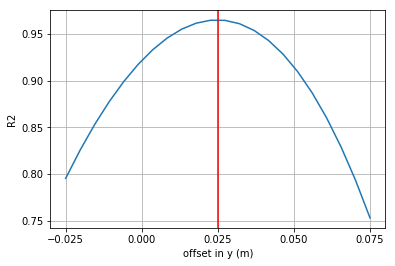

In [271]:
# moving in y
y_offsets = np.linspace(-2.5e-2,7.5e-2,22)
r2_scores = []
for offset in y_offsets:
    X_test_ = X_test.copy()
    X_test_[:,0:3] += np.array([0, offset, 0])
    X_train_scaled, X_test_scaled = feature_scaling_forGridSearch(X_train, X_test_)
    predictions = model.predict(X_test_scaled)
    r2_scores.append(r2_score(predictions, reference))
plt.plot(y_offsets, r2_scores)
plt.xticks([-0.025, 0, 0.025, 0.05,0.075])
plt.grid()
plt.axvline(0.025, color='r')
plt.xlabel('offset in y (m)')
plt.ylabel('R2')

Text(0,0.5,'R2')

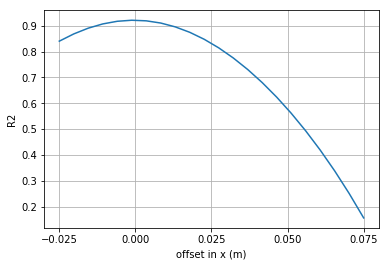

In [277]:
# moving in x
x_offsets = np.linspace(-2.5e-2,7.5e-2,22)
r2_scores = []
for offset in x_offsets:
    X_test_ = X_test.copy()
    X_test_[:,0:3] += np.array([offset,0, 0])
    X_train_scaled, X_test_scaled = feature_scaling_forGridSearch(X_train, X_test_)
    predictions = model.predict(X_test_scaled)
    r2_scores.append(r2_score(predictions, reference))
plt.plot(y_offsets, r2_scores)
plt.xticks([-0.025, 0, 0.025, 0.05,0.075])
plt.grid()
plt.xlabel('offset in x (m)')
plt.ylabel('R2')

# Current Ramps on MLP

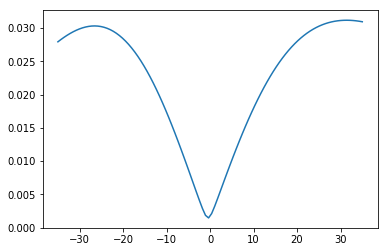

In [336]:
# ramping up currents
ramp = np.linspace(-35,35,100)
x = np.zeros((100,11))
x[:,10] = ramp
X_train_scaled_, X_test_scaled = feature_scaling_forGridSearch(X_train, x)
plt.plot(ramp,np.linalg.norm(model.predict(X_test_scaled),axis=1))